In [1]:
%matplotlib inline
import string
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image
import six.moves.cPickle as pickle
from operator import itemgetter, attrgetter
ITER_TAG = "Iteration"
TST_TAG_LIST = ["overall accuracy", "mean accuracy", "mean IU", "fwavacc", "per-class IU", 'loss']

In [3]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def draw(x, y, xlabel='Iterations', ylabel='', moving_average_window = 1, ylim=[], save=False, model="", sci=False):
    y_avg = movingaverage(y, moving_average_window)
    
    plt.rcParams['figure.figsize'] = (20.0, 16.0)
    if len(ylim)==2:
        plt.gca().set_ylim(ylim)
    plt.gca().set_xlim([0, max(x)])
    plt.plot(x,y_avg)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    if sci:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if save:
        plt.savefig("plot/"+model+"-"+ylabel+".pdf")
    plt.show()

In [35]:
model = 'fcnResNet152' # Set Model Name, should be same as folder name
weight_folder = 'log2-ImageNet' # Set The Snapshot Folder

model_path = '../siftflow-' + model+ '/'+ weight_folder + '/'
Log = model_path + "training-info.log"

def find_loss(splt):
    splt = line.split(' ')
    ind = splt.index("=") + 1
    return float(splt[ind])

loss = {"sem":[],"geo":[], "overall":[]}
with open(Log,"r") as infile:
    for line in infile:
        splt = line.split(' ')
        if ITER_TAG in splt and "=" in splt and (not "lr" in splt):
            ind = splt.index(ITER_TAG)
            itr_string = splt[ind+1]
            if itr_string[-1] != ",":
                print "Something is Wrong", line
                break
            itr = int(itr_string[:-1])
            loss["overall"].append( (itr, find_loss(line) ) )
            loss["sem"].append( (itr, find_loss(next(infile)) ) )
            loss["geo"].append( (itr, find_loss(next(infile)) ) )

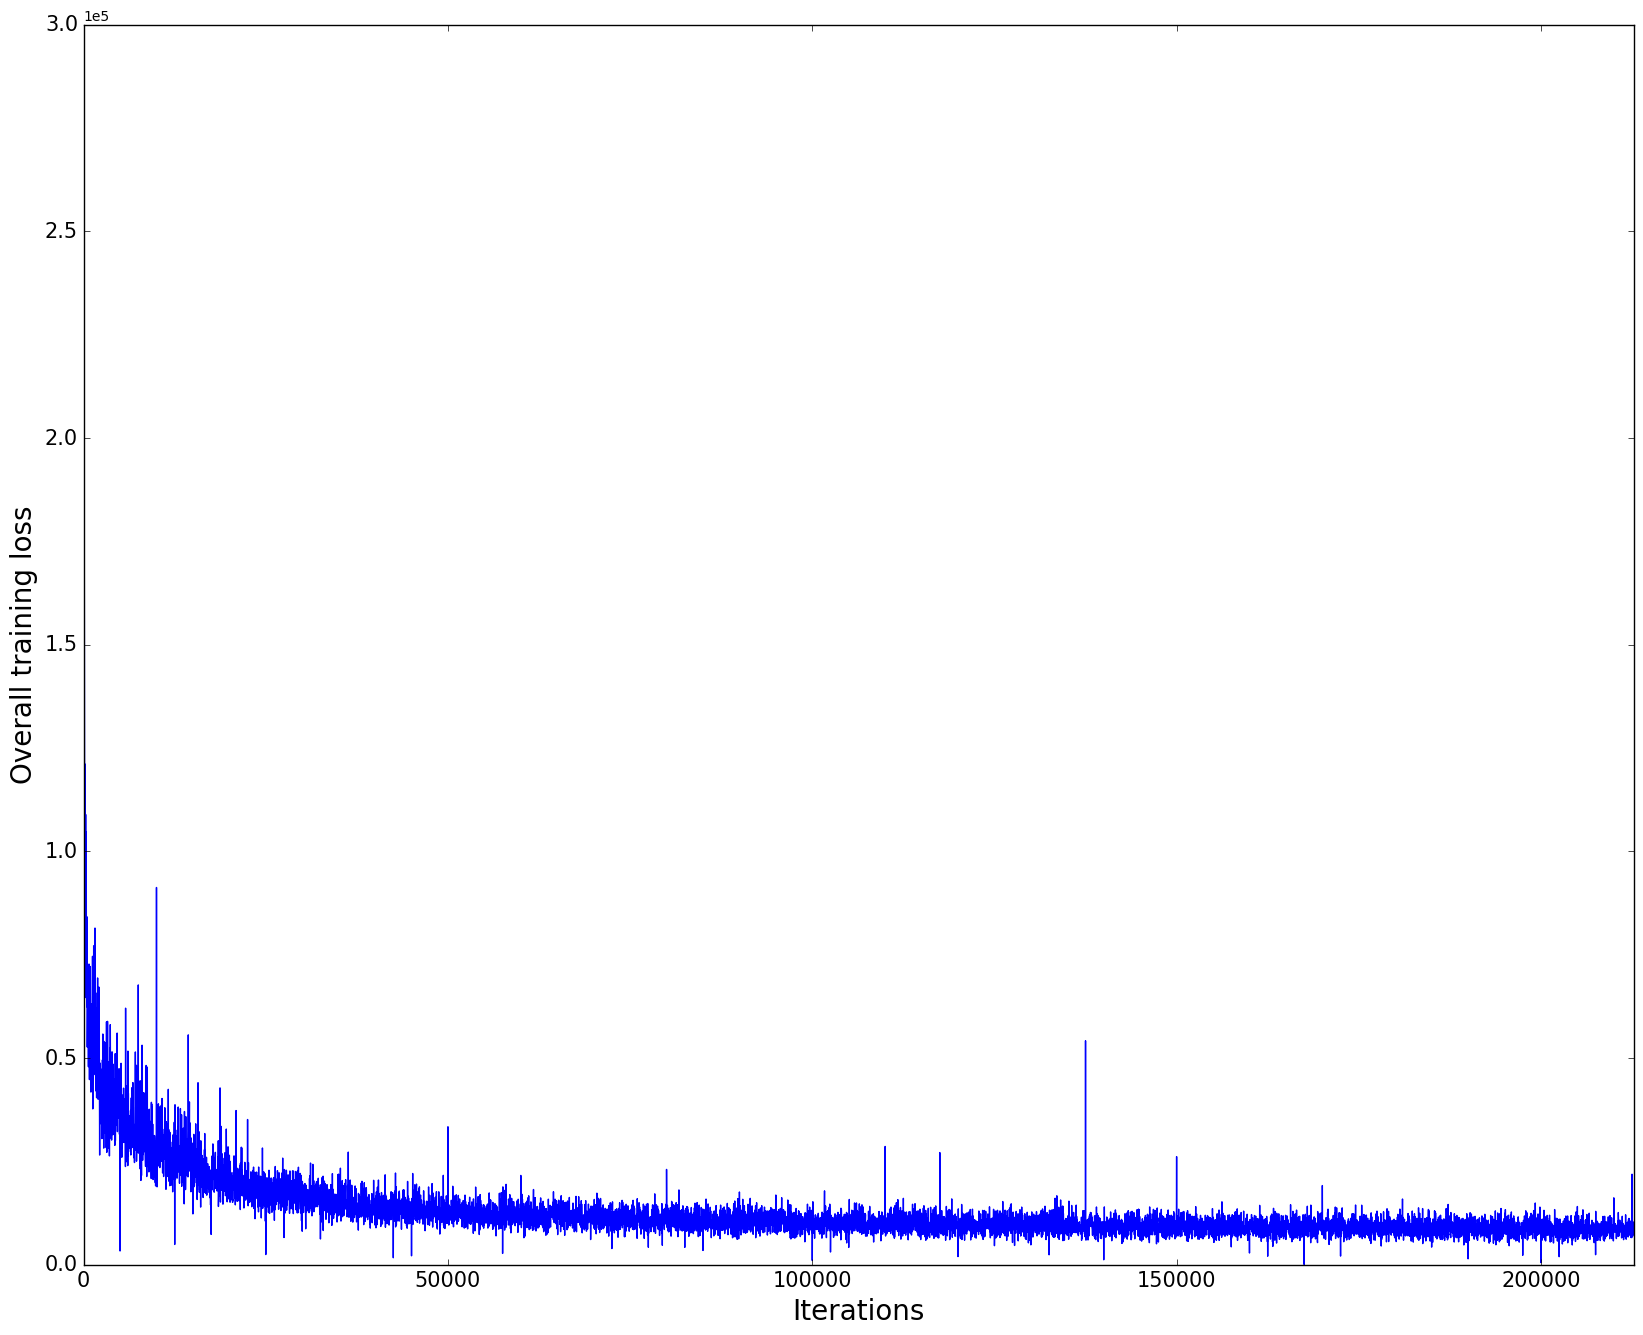

In [37]:
#draw(*zip(*loss["overall"]), ylabel="Training loss overall", ylim = [1000,100000], xlim=[0,200000], save=False,model=model)
draw(*zip(*loss["overall"]), ylabel="Overall training loss", save=True, ylim = [0,3e5],  model=model, sci=True)

#draw(*zip(*loss["sem"]), ylabel="Training loss sem", ylim = [1000,100000], xlim=[0,200000], save=False,model=model)
#draw(*zip(*loss["geo"]), ylabel="Training loss geo", ylim = [1000,100000], xlim=[0,200000], save=False,model=model)

In [38]:
def find_best(sem, geo):
    sorted_lst = sorted(sem, key=lambda model: model["mean IU"], reverse=True)
    sem_model = sorted_lst[0]
    itr = sem_model["Iteration"]
    geo_model = [x for x in geo if x["Iteration"]==itr][0]
    print "Best Model is at iteration:", itr
    return sem_model,geo_model

def model_plot(sem, geo, save, model):
    iters = [ x["Iteration"] for x in sem ]
    mean_IU = [ y["mean IU"] *100 for y in sem ]
    ove_acc_sem = [ y["overall accuracy"] * 100 for y in sem ]
    ove_acc_geo = [ y["overall accuracy"] * 100 for y in geo ]

    draw(iters,mean_IU, ylabel="Mean IU (%)", ylim =  [min(mean_IU)-1, max(mean_IU)+1], save=save, model=model)
    draw(iters,ove_acc_sem, ylabel="Semantic pixel acc. (%)", ylim=[min(ove_acc_sem)-1, max(ove_acc_sem)+1], save=save, model=model)
    draw(iters,ove_acc_geo, ylabel="Geometric pixel acc. (%)", ylim=[min(ove_acc_geo)-1, max(ove_acc_geo)+1], save=save, model=model)

def load_class_names():
    sem_names = []
    with open("../data/sift-flow/classes.txt","r") as f:
        for _ in xrange(4):
            next(f)
        for _ in xrange(1,34):
            sem_names.append(next(f).split(' ')[1][:-1])
    return sem_names

def write_PerClassIU(IU_list, model):
    with open("Per-ClassIU-3.txt","a") as f:
        sem_names = load_class_names()
        f.write("===============\n"+model+"\n")
        lst = []
        for i, name in enumerate(sem_names):
            lst.append( (name, IU_list[i]) ) 
        for line in sorted(lst, key = itemgetter(1) , reverse=True):
            if  not (line[0] in ["cow", "desert", "moon"] ):
                f.write(line[0] + " ")
                f.write("%2.1f\n" % (line[1] * 100) )
        

In [40]:
models = ['fcnResNet152-skip','fcn8s-distilled','fcnResNet152','fcnResNet101','fcnResNet50', 'fcn16s','fcn32s','fcn8s']
weights = ['log1','log1','log2-ImageNet','log1-ImageNet','log1-ImageNet','', '', '']


for model, weight in zip(models, weights):
    print "===================="
    print 'Model Name:', model
    sem = pickle.load(open(model + '-' + weight + '-sem.pkl'))
    geo = pickle.load(open(model + '-' + weight + '-geo.pkl'))
    best_model = find_best(sem, geo)
    for tag in TST_TAG_LIST:
        if tag != "loss" and tag != "per-class IU":
            print tag + ": %2.1f" % (best_model[0][tag]*100)
    write_PerClassIU(best_model[0]["per-class IU"], model)
    
    print "geom. acc. : %2.1f" % (best_model[1]["overall accuracy"]*100)
    if len(model)>7:
        model_plot(sem, geo, True, model)
    

Model Name: fcnResNet152-skip
Best Model is at iteration: 97500
overall accuracy: 86.3
mean accuracy: 50.0
mean IU: 38.8
fwavacc: 77.7
geom. acc. : 95.0
Model Name: fcn8s-distilled
Best Model is at iteration: 275000
overall accuracy: 86.3
mean accuracy: 48.4
mean IU: 38.4
fwavacc: 77.2
geom. acc. : 94.6
Model Name: fcnResNet152
Best Model is at iteration: 62500
overall accuracy: 84.9
mean accuracy: 47.5
mean IU: 36.7
fwavacc: 75.7
geom. acc. : 94.3
Model Name: fcnResNet101
Best Model is at iteration: 102500
overall accuracy: 84.5
mean accuracy: 46.1
mean IU: 35.5
fwavacc: 75.0
geom. acc. : 94.0
Model Name: fcnResNet50
Best Model is at iteration: 135000
overall accuracy: 83.9
mean accuracy: 46.0
mean IU: 34.9
fwavacc: 74.2
geom. acc. : 93.8
Model Name: fcn16s
Best Model is at iteration: 2500
overall accuracy: 84.9
mean accuracy: 51.7
mean IU: 38.0
fwavacc: 75.7
geom. acc. : 93.8
Model Name: fcn32s
Best Model is at iteration: 2500
overall accuracy: 84.3
mean accuracy: 44.7
mean IU: 33.9
